In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

### The calss

In [2]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')




################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

### Load the data

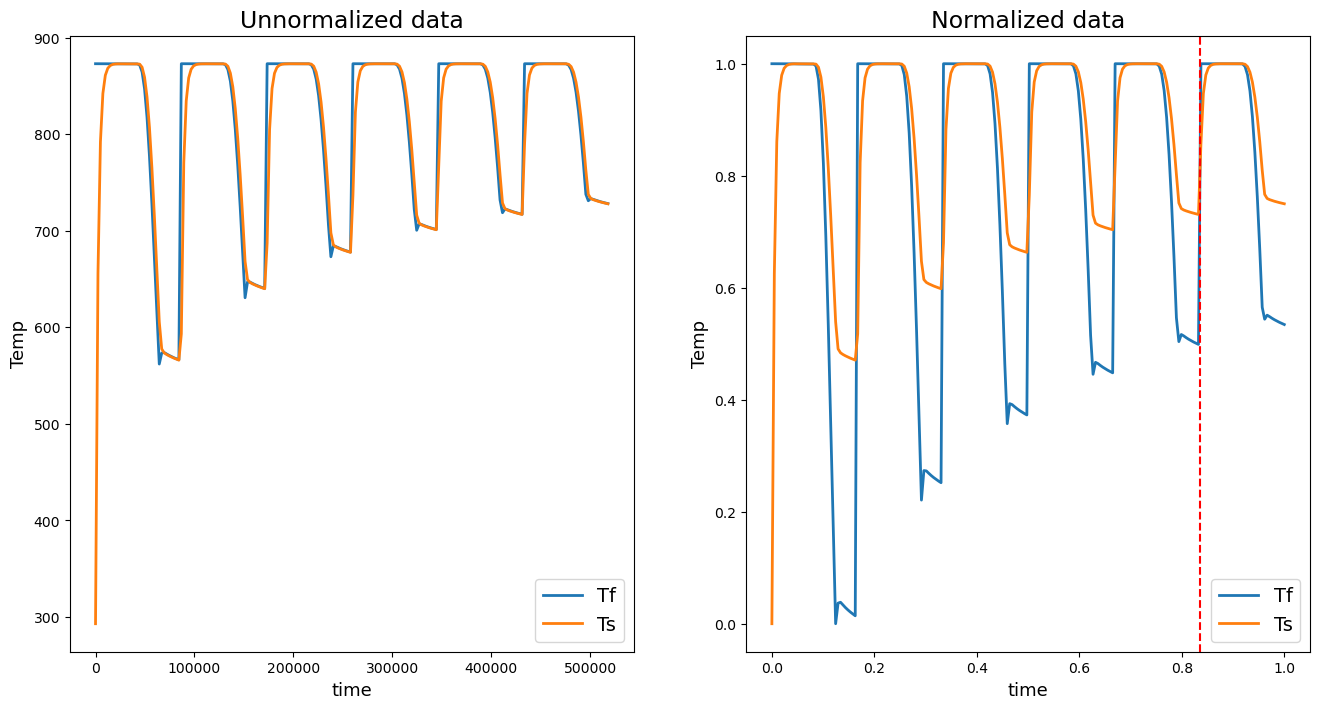

In [3]:
# Load the data from the file
df_data = pd.read_csv('TrainingData.txt')

# Unnormalized data
t_data = torch.tensor(df_data['t'].values, dtype=torch.float)
Tf_data = torch.tensor(df_data['tf0'].values, dtype=torch.float)
Ts_data = torch.tensor(df_data['ts0'].values, dtype=torch.float)

# Normalized data
t_data_norm = (t_data - t_data.min()) / (t_data.max() - t_data.min())
Tf_data_norm = (Tf_data - Tf_data.min()) / (Tf_data.max() - Tf_data.min())
Ts_data_norm = (Ts_data - Ts_data.min()) / (Ts_data.max() - Ts_data.min())


# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# unnormalized data
axs[0].plot(t_data, Tf_data, label='Tf', linewidth=2)
axs[0].plot(t_data, Ts_data, label='Ts', linewidth=2)
axs[0].set_xlabel('time', size=13)
axs[0].set_ylabel('Temp', size=13)
axs[0].legend(fontsize=14)
axs[0].set_title('Unnormalized data', size=17)

# normalized data
axs[1].plot(t_data_norm, Tf_data_norm, label='Tf', linewidth=2)
axs[1].plot(t_data_norm, Ts_data_norm, label='Ts', linewidth=2)
axs[1].set_xlabel('time', size=13)
axs[1].set_ylabel('Temp', size=13)
axs[1].legend(fontsize=14)
axs[1].set_title('Normalized data', size=17)
axs[1].axvline(x=0.835, color='r', linestyle='--')  

### Train the FNO

In [4]:
# Devide the data into training and testing
train_perc = 1

com_div = 35

t_train = t_data_norm[:int(len(t_data)*train_perc)].reshape(-1)
Tf_train = Tf_data_norm[:int(len(Tf_data)*train_perc)].reshape(-1)
Ts_train = Ts_data_norm[:int(len(Ts_data)*train_perc)].reshape(-1)

t_test = t_data_norm[int(len(t_data)*train_perc):].reshape(-1)
Tf_test = Tf_data_norm[int(len(Tf_data)*train_perc):].reshape(-1)
Ts_test = Ts_data_norm[int(len(Ts_data)*train_perc):].reshape(-1)

print('Training data size:\t', len(t_train))
print('Testing data size:\t', len(t_test))

# Make the data for the Tf-FNO in the correct format

# IS USING Tf as the a(x) --> MAKE SURE IS NOT TO BE USED Ts as a(x)
input_Tf = torch.stack([Tf_data_norm.reshape(-1), t_data_norm.reshape(-1)], dim=1).reshape(-1, com_div, 2)  # we want (a(x), x)
print(input_Tf.shape)
input_train_Tf = input_Tf[:-1, :]
# input_test_Tf = input_Tf[1:, :]

output_train_Tf = Tf_data_norm.reshape(-1, com_div)[1:, :]
# output_test_Tf = Tf_data_norm.reshape(-1, com_div)[-1:]

print("\n---------------------------------")
print("FOR Tf-FNO")
print("---------------------------------")
print("input_train_Tf.shape:\t", input_train_Tf.shape)
print("output_train_Tf.shape:\t", output_train_Tf.shape)
# print("\ninput_test_Tf.shape:\t", input_test_Tf.shape)
# print("output_test_Tf.shape:\t", output_test_Tf.shape)
print("---------------------------------")

# # Make the data for the Ts-FNO in the correct format
# input_train_Ts = torch.stack([Tf_train, t_train], dim=1).reshape(-1, 42, 2)   # we want (a(x), x)
# input_test_Ts = torch.stack([Tf_test, t_test], dim=1).reshape(-1, 42, 2) 

# output_train_Ts = Ts_train.reshape(-1, 42)
# output_test_Ts = Ts_test.reshape(-1, 42)

# print("\n---------------------------------")
# print("FOR Ts-FNO")
# print("---------------------------------")
# print("input_train_Ts.shape:\t", input_train_Ts.shape)
# print("output_train_Ts.shape:\t", output_train_Ts.shape)
# print("\ninput_test_Ts.shape:\t", input_test_Ts.shape)
# print("output_test_Ts.shape:\t", output_test_Ts.shape)


# Define the batch size and load the Dataset
batch_size = 2

# For Tf-FNO
training_set_Tf = DataLoader(TensorDataset(input_train_Tf, output_train_Tf), batch_size=batch_size, shuffle=True)
# testing_set_Tf = DataLoader(TensorDataset(input_test_Tf, output_test_Tf), batch_size=batch_size, shuffle=False)

# # For Ts-FNO
# training_set_Ts = DataLoader(TensorDataset(input_train_Ts, output_train_Ts), batch_size=batch_size, shuffle=True)
# testing_set_Ts = DataLoader(TensorDataset(input_test_Ts, output_test_Ts), batch_size=batch_size, shuffle=False)

Training data size:	 210
Testing data size:	 0
torch.Size([6, 35, 2])

---------------------------------
FOR Tf-FNO
---------------------------------
input_train_Tf.shape:	 torch.Size([5, 35, 2])
output_train_Tf.shape:	 torch.Size([5, 35])
---------------------------------


In [5]:
for step, (input_batch, output_batch) in enumerate(training_set_Tf):
    if step == 0:
        print('input_batch.shape: ', input_batch.shape)
        print('output_batch.shape: ', output_batch.shape)

input_batch.shape:  torch.Size([2, 35, 2])
output_batch.shape:  torch.Size([2, 35])


In [6]:
learning_rate = 0.001

epochs = 2500
# epochs = 1
step_size = 50
gamma = 0.5

modes = 17
width = 64

# model

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width)

In [7]:
# Train the Tf FNO
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    scheduler.step()

    # with torch.no_grad():
    #     fno_Tf.eval()
    #     test_relative_l2 = 0.0
    #     for step, (input_batch, output_batch) in enumerate(testing_set_Tf):
    #         output_pred_batch = fno_Tf(input_batch).squeeze(2)
    #         loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
    #         test_relative_l2 += loss_f.item()
    #     test_relative_l2 /= len(testing_set_Tf)

    # if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)
    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:")


######### Epoch: 0  ######### Train Loss: 0.2668347805738449  ######### Relative L2 Test Norm:
######### Epoch: 1  ######### Train Loss: 0.05656530956427256  ######### Relative L2 Test Norm:
######### Epoch: 2  ######### Train Loss: 0.03971062880009413  ######### Relative L2 Test Norm:
######### Epoch: 3  ######### Train Loss: 0.017609603858242433  ######### Relative L2 Test Norm:
######### Epoch: 4  ######### Train Loss: 0.027258063045640785  ######### Relative L2 Test Norm:
######### Epoch: 5  ######### Train Loss: 0.0056331475886205835  ######### Relative L2 Test Norm:


######### Epoch: 6  ######### Train Loss: 0.012590582792957624  ######### Relative L2 Test Norm:
######### Epoch: 7  ######### Train Loss: 0.00580308665909494  ######### Relative L2 Test Norm:
######### Epoch: 8  ######### Train Loss: 0.00302866636775434  ######### Relative L2 Test Norm:
######### Epoch: 9  ######### Train Loss: 0.004741245104620854  ######### Relative L2 Test Norm:
######### Epoch: 10  ######### Train Loss: 0.002089904504828155  ######### Relative L2 Test Norm:
######### Epoch: 11  ######### Train Loss: 0.002280988536464671  ######### Relative L2 Test Norm:
######### Epoch: 12  ######### Train Loss: 0.002071449727130433  ######### Relative L2 Test Norm:
######### Epoch: 13  ######### Train Loss: 0.0010338883827595662  ######### Relative L2 Test Norm:
######### Epoch: 14  ######### Train Loss: 0.0014570181956514716  ######### Relative L2 Test Norm:
######### Epoch: 15  ######### Train Loss: 0.0010490187172157068  ######### Relative L2 Test Norm:
######### Epoch: 16  ##

### Plot the trained part

torch.Size([1, 35, 2])
Relative L2 error:  0.6690961718559265
torch.Size([1, 35, 2])
Relative L2 error:  0.6177211403846741
torch.Size([1, 35, 2])
Relative L2 error:  0.4725942015647888
torch.Size([1, 35, 2])
Relative L2 error:  0.1271454095840454
torch.Size([1, 35, 2])
Relative L2 error:  0.4623572826385498


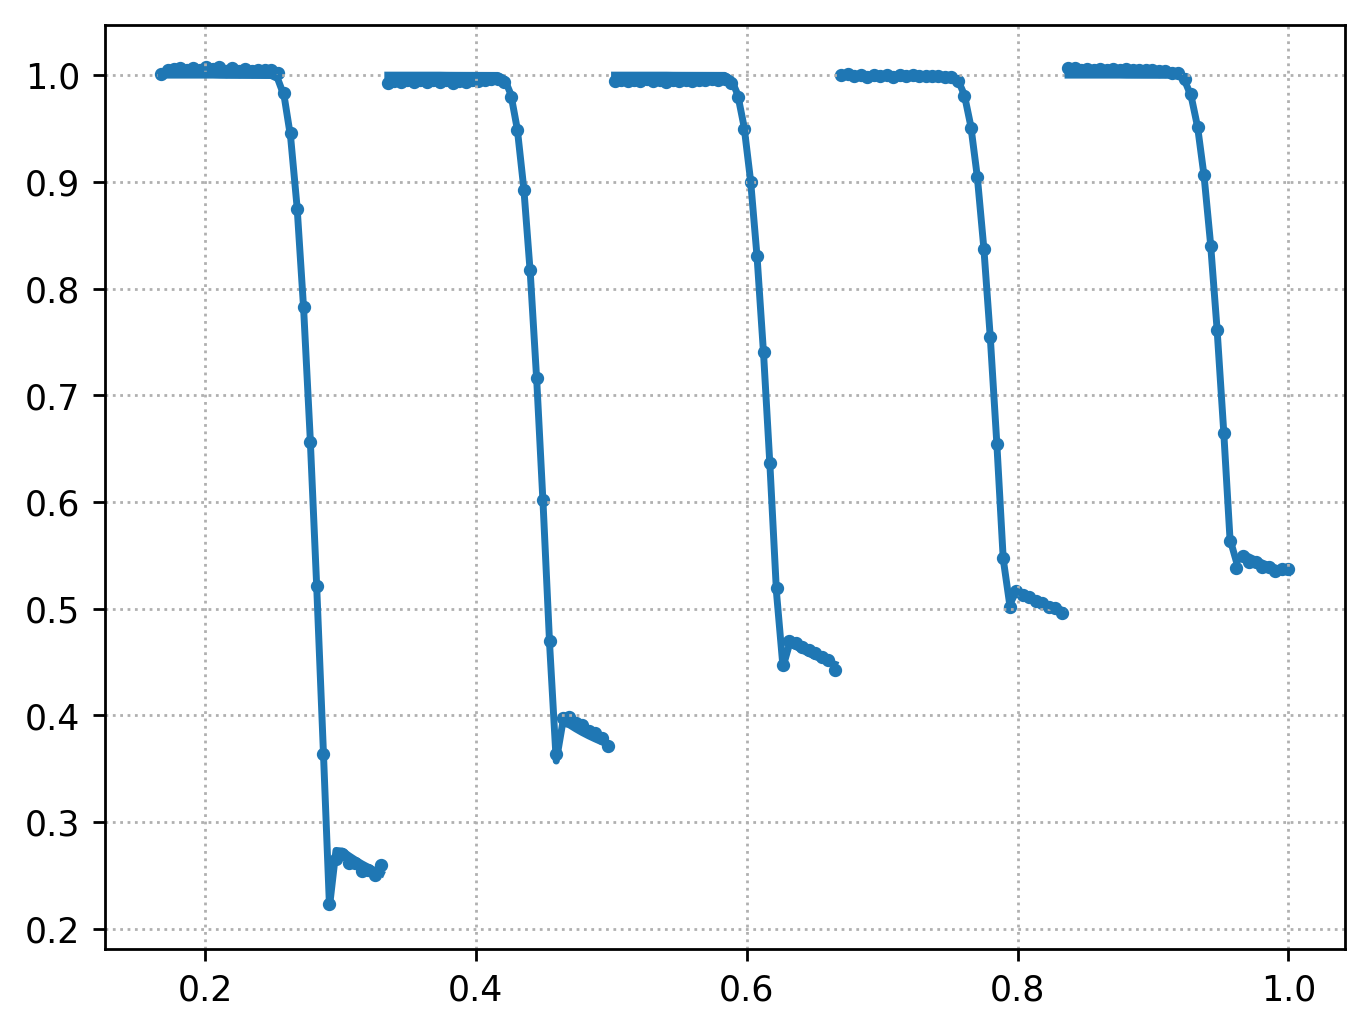

In [8]:
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
for i in range(input_train_Tf.shape[0]):

    input_function_test_n = input_train_Tf[i, :].unsqueeze(0)
    print(input_function_test_n.shape)
    output_function_test_n = output_train_Tf[i, :].unsqueeze(0)

    output_function_test_pred_n = fno_Tf(input_function_test_n)
    
    plt.plot(input_Tf.reshape(-1,2)[(i+1)*com_div:(i+1)*com_div+com_div, 1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
    plt.scatter(input_Tf.reshape(-1,2)[(i+1)*com_div:(i+1)*com_div+com_div, 1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")
    p = 2
    err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
    print("Relative L2 error: ", err.item())

# # plt.legend()
# print()
# print("New Error:")
# for i in range(2):
#     input_function_test_n = input_test_Tf[i, :].unsqueeze(0)
#     output_function_test_n = output_test_Tf[i, :].unsqueeze(0)

#     output_function_test_pred_n = fno_Tf(input_function_test_n)

#     plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
#     plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")
#     p = 2
#     err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
    
#     print("Relative L2 error: ", err.item())



### Make prediction